In [1]:
import numpy as np
import gensim.downloader as api
from scipy.stats import spearmanr
import os
from cuml.manifold import TSNE
import cudf
import numpy as np
import cupy as cp
from gensim.models import KeyedVectors
import csv
import pandas as pd

In [2]:
class ReducedEmbeddingModel:
    def __init__(self, vectors, index_to_key):
        self.vectors = vectors
        self.index_to_key = index_to_key
        self.key_to_index = {word: idx for idx, word in enumerate(index_to_key)}
    
    def __getitem__(self, word):
        if word in self.key_to_index:
            return self.vectors[self.key_to_index[word]]
        raise KeyError(f"Word '{word}' not found in vocabulary")
    
    def __contains__(self, word):
        return word in self.key_to_index

def load_word2vec_model(file_path):
    """Loads Word2Vec embeddings from a binary file."""
    print("Loading Word2Vec model...")
    wv = KeyedVectors.load_word2vec_format(file_path, binary=True)
    vectors = wv.vectors
    index_to_key = wv.index_to_key
    return ReducedEmbeddingModel(vectors, index_to_key)
    
import time

def tsne_dimensionality_reduction(embeddings, target_dim, perplexity, learning_rate=200):
    """
    Reduces dimensions of embeddings using GPU-accelerated t-SNE.

    Parameters:
        embeddings (numpy.ndarray): Input high-dimensional embeddings (e.g., FastText) as a NumPy array.
        target_dim (int): Number of dimensions for the reduced space. Default is 2.
        perplexity (float): t-SNE perplexity parameter. Default is 30.
        learning_rate (float): Learning rate for optimization. Default is 200.

    Returns:
        numpy.ndarray: Reduced dimensionality embeddings.
    """
    print(f"Loading embeddings into GPU memory and initializing t-SNE with {target_dim} dimensions...")

    # Convert embeddings to a GPU DataFrame (cudf)
    embeddings_gpu = cudf.DataFrame.from_records(embeddings)

    # Initialize GPU-accelerated t-SNE
    tsne = TSNE(
        n_components=target_dim,
        perplexity=perplexity,
        learning_rate=learning_rate,
        random_state=42,  # For reproducibility
        verbose=1         # Enables progress output
    )

    print("Starting t-SNE dimensionality reduction...")
    start_time = time.time()  # Start timing

    # Perform dimensionality reduction
    reduced_embeddings = tsne.fit_transform(embeddings_gpu)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    print(f"t-SNE completed in {elapsed_time:.2f} seconds.")

    return reduced_embeddings.to_pandas().to_numpy()  # Convert back to NumPy array if needed

# Load SimLex-999 word similarity data
def load_simlex_999(file_path):
    """Loads SimLex-999 and returns word pairs with similarity scores."""
    data = []
    with open(file_path, 'r') as file:
        next(file)  # Skip the header
        for line in file:
            parts = line.strip().split('\t')
            word1, word2, similarity_score = parts[0], parts[1], float(parts[3])
            data.append((word1, word2, similarity_score))
    return data

# Cosine similarity function for similarity evaluation
def cosine_similarity(v1, v2):
    """Calculates cosine similarity between two vectors."""
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)

# Evaluate embeddings on the SimLex-999 data
def evaluate_embeddings(model, word_pairs):
    """Evaluates embeddings using SimLex-999 data and Spearman correlation."""
    predicted_scores = []
    true_scores = []

    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1], model[word2])
            predicted_scores.append(sim_score)
            true_scores.append(true_score)

    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

In [3]:
word2vec_file_path = '/teamspace/uploads/GoogleNews-vectors-negative300.bin'  # Path to your Word2Vec binary file
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'  # Update this path to your SimLex-999 file
target_dim = 2  # Adjust target_dim as needed for testing (e.g., 150, 100, 50)

In [4]:
# Load Word2Vec model
original_model = load_word2vec_model(word2vec_file_path)
word_pairs = load_simlex_999(simlex_file_path)

Loading Word2Vec model...


In [5]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings1 = None

# List of perplexity values to evaluate
perplexities = [5, 15, 25, 35, 45]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings1 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=5...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 1897.54 seconds.
Spearman Correlation for perplexity=5: 0.1268

Performing t-SNE with perplexity=15...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 1909.73 seconds.
Spearman Correlation for perplexity=15: -0.0072

Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/zeus/miniconda3/envs/cloudspace/include/rmm/mr/device/cuda_memory_resource.hpp

In [6]:
import pandas as pd
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [7]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
######### RENAME AS PER THE BEST RESULT
file_path="Word2Vec_TSNE_2d_word_embeddings_.csv"
# Save the embeddings and words to a CSV file
######### UPDATE THE optimized_embeddings variable as per the best result
save_embeddings_to_csv(words, optimized_embeddings1, file_path)

Saving 2D embeddings to Word2Vec_TSNE_2d_word_embeddings_.csv...
2D embeddings saved successfully.


In [5]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings1 = None

# List of perplexity values to evaluate
perplexities = [25, 35, 45, 55, 65]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings1 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 1902.10 seconds.
Spearman Correlation for perplexity=25: 0.1299

Performing t-SNE with perplexity=35...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 1907.26 seconds.
Spearman Correlation for perplexity=35: 0.1312

Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/zeus/miniconda3/envs/cloudspace/include/rmm/mr/device/cuda_memory_resource.hpp

In [5]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings1 = None

# List of perplexity values to evaluate
perplexities = [45, 55, 65, 75, 85]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings1 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 1920.82 seconds.
Spearman Correlation for perplexity=45: 0.0402

Performing t-SNE with perplexity=55...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 1928.12 seconds.
Spearman Correlation for perplexity=55: 0.0464

Performing t-SNE with perplexity=65...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/zeus/miniconda3/envs/cloudspace/include/rmm/mr/device/cuda_memory_resource.hpp

In [ ]:
import pandas as pd
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [ ]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
######### RENAME AS PER THE BEST RESULT
file_path="Word2Vec_TSNE_2d_word_embeddings_new1.csv"
# Save the embeddings and words to a CSV file
######### UPDATE THE optimized_embeddings variable as per the best result
save_embeddings_to_csv(words, optimized_embeddings1, file_path)

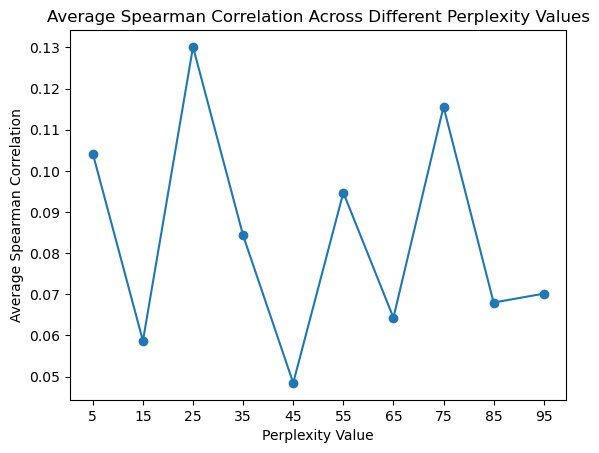

In [1]:
import matplotlib.pyplot as plt

spearman_correlations_list1 = [0.1268, -0.0072, 0.1299, 0.1312, 0.0402, 0.0464, 0.1407, 0.1306, 0.1027, 0.0331]
spearman_correlations_list2 = [0.1098, 0.0906, 0.1301, 0.0159, 0.0389, 0.1242, 0.1246, 0.1294, 0.0790, 0.0500]
spearman_correlations_list3 = [0.0428, 0.0135, 0.1688, 0.0471, 0.0508, 0.1284, -0.0300, 0.0991, -0.0154, 0.0122]
spearman_correlations_list4 = [0.0704, 0.1288, 0.0891, 0.1815, 0.0784, 0.0521, 0.0669, 0.0758, 0.0937, 0.1350]
spearman_correlations_list5 = [0.1711, 0.0676, 0.1327, 0.0457, 0.0339, 0.1224, 0.0193, 0.1430, 0.0799, 0.1204]

all_lists = [
    spearman_correlations_list1,
    spearman_correlations_list2,
    spearman_correlations_list3,
    spearman_correlations_list4,
    spearman_correlations_list5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_list1)):
    index_values = [lst[i] for lst in all_lists]
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of perplexity values from 5 to 95 with intervals of 10
perplexity_values = list(range(5, 96, 10))  # [5, 15, 25, ..., 85, 95]

# Plot the index averages in a line graph
plt.plot(perplexity_values, index_averages, marker='o')

# Add labels and title
plt.xlabel("Perplexity Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Perplexity Values")

# Customize the x-axis ticks
plt.xticks(perplexity_values)

# Display the plot
plt.show()